In [1]:
import random
import os
import numpy as np
import pandas as pd
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
random_seed = 1
random.seed(random_seed)
numpy_seed = 1
np.random.seed(numpy_seed)
tensorflow_seed = 1
tf.random.set_seed(tensorflow_seed)

In [3]:
def face_detect(test_img, 
                haar_path="../input/haarcascade-frontalface-model/haarcascade_frontalface_default.xml",
                dim = (160,160)):
    '''
    Detect face
    '''
    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(haar_path)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.10, minNeighbors=5, minSize=(40,40))
    if len(faces) != 1:
        return None
    (x, y, w, h) = faces[0]
    area_proportion = (w*h)/(gray_img.shape[0]*gray_img.shape[1])
    if area_proportion<=0.20:
        return None
    cropped_img = test_img[y:y+h, x:x+w]  
    cropped_img = cv2.resize(cropped_img, dim, interpolation = cv2.INTER_AREA)
    
    return cropped_img

def gaussian_transformation(img, kernel_size = 3):
    '''
    Introduce gaussian blur
    '''
    blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),
                                   cv2.BORDER_DEFAULT)
    return blurred_img

def flip_transformation(img):  
    '''
    Flip image horizontally
    '''
    return cv2.flip(img, 1)

def rotation_transformation(img, angle):
    '''
    Rotate image by an angle
    '''    
    return (rotate(img, angle)*255).astype("uint8")

def noise_transformation(img, mean, var):
    '''
    Introduce noise in image
    '''
    noisy_image= random_noise(img,
                              mean = mean,
                              var = var)
    return (noisy_image*255).astype("uint8")

def horizontal_translation(img, 
                           horizontal_translation_ratio): 
    """
    horizaontal_translation
    """
    horizontal_translation = int(img.shape[1]*horizontal_translation_ratio)
    transform = AffineTransform(translation=(horizontal_translation,0))
    return (warp(img,transform, mode="wrap")*255).astype("uint8")

def random_float(low, high):
    return random.random()*(high-low) + low

In [4]:
def augment_image(image):
    """
    Randomly augment image
    """
    if np.random.choice([0,1]) == 0:
        return image
    if np.random.choice([0,1]) == 0:
        kernel_size = np.random.choice([1,3,5,7])
        image = gaussian_transformation(image, kernel_size = kernel_size)
    else:
        mean = random_float(0.0, 0.03)
        var = random_float(0.0, 0.05)
        image = noise_transformation(image, mean, var)
       
    if np.random.choice([0,1]) == 0:
        image = flip_transformation(image)
        
    angle = np.random.randint(low = -8, high= 8)    
    image = rotation_transformation(image, angle) 
    
    horizontal_translation_ratio = random_float(0.00, 0.05)
    if np.random.choice([0,1]) == 0:
        image = horizontal_translation(image, -horizontal_translation_ratio)
    else:
        image = horizontal_translation(image, horizontal_translation_ratio)
    
    return image

In [5]:
face_dir = "../input/vggface2-test/test/"
face_list = os.listdir(face_dir)
random.shuffle(face_list)
train_list = face_list[:int(0.85*len(face_list))]
valid_list = face_list[int(0.85*len(face_list)):]

In [6]:
def create_batch(batch_size, face_dir, face_list, dim = (160, 160)):
    
    """
    Create image batch
    """
    postive_size = batch_size//2
    negative_size = batch_size - (batch_size//2)
    X1_positives = np.zeros(shape = (postive_size,dim[0],dim[1], 3), dtype = "float32")
    X2_positives = np.zeros(shape = (postive_size,dim[0],dim[1], 3), dtype = "float32")
    X1_negatives = np.zeros(shape = (negative_size,dim[0],dim[1], 3), dtype = "float32")
    X2_negatives = np.zeros(shape = (negative_size,dim[0],dim[1], 3), dtype = "float32")
    
    counter = 0
    while counter<postive_size:
        random_person = np.random.choice(face_list)
        random_person_dir = os.path.join(face_dir,random_person)
        photos = os.listdir(random_person_dir)
        photo1 = np.random.choice(photos)
        photo2 = np.random.choice(photos)
        while photo1 == photo2:    
            photo1 = np.random.choice(photos)
            photo2 = np.random.choice(photos)
        dir1=random_person_dir+"/"+photo1  
        dir2=random_person_dir+"/"+photo2 
        try:
            photo1 = face_detect(cv2.imread(dir1))
            photo2 = face_detect(cv2.imread(dir2))
            if np.isnan(photo1).any():
                5/0
            if np.isnan(photo2).any():
                5/0
            X1_positives[counter] = photo1
            X2_positives[counter] = photo2
            counter +=1
        except:
            continue
        
    counter = 0
    while counter<negative_size:
        random_person_1 = np.random.choice(face_list)
        random_person_2 = np.random.choice(face_list)
        while random_person_1 == random_person_2:    
            random_person_1 = np.random.choice(face_list)
            random_person_2 = np.random.choice(face_list)
        random_person_1_dir = os.path.join(face_dir,random_person_1)
        random_person_2_dir = os.path.join(face_dir,random_person_2)
        photos1 = os.listdir(random_person_1_dir)
        photos2 = os.listdir(random_person_2_dir)
        photo1 = np.random.choice(photos1)
        photo2 = np.random.choice(photos2)
        dir1=random_person_1_dir+"/"+photo1  
        dir2=random_person_2_dir+"/"+photo2 
        try:
            photo1 = face_detect(cv2.imread(dir1))
            photo2 = face_detect(cv2.imread(dir2))
            if np.isnan(photo1).any():
                5/0
            if np.isnan(photo2).any():
                5/0
            X1_negatives[counter] = photo1
            X2_negatives[counter] = photo2
            counter +=1
        except:
            continue
    X1 = np.concatenate([X1_positives, X1_negatives], axis = 0).astype('float32')
    X2 = np.concatenate([X2_positives, X2_negatives], axis = 0).astype('float32')
    y = np.array([1 for i in range(postive_size)] + 
                 [0 for i in range(negative_size)]).astype('int32').reshape(-1,1)
    return X1, X2, y

In [7]:
X1, X2, y = create_batch(1024*4, face_dir, face_list)

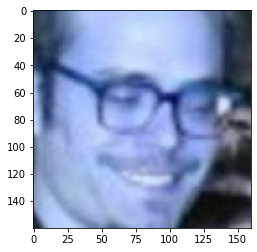

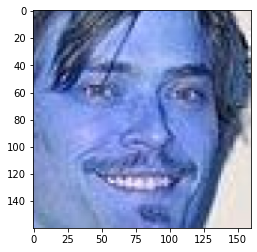

In [8]:
index = 2000
plt.imshow(X1[index].astype("uint8"))
plt.show()
plt.imshow(X2[index].astype("uint8"))
plt.show()

In [9]:
facenet_path = "../input/facenet-keras/facenet_keras.h5"
facenet = tf.keras.models.load_model(facenet_path)

In [10]:
cosine_loss = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)

In [11]:
for n in range(len(X1)):
    mean, std = X1[n].mean(), X1[n].std()
    X1[n] = (X1[n]-mean)/(std+1e-4)
for n in range(len(X2)):
    mean, std = X2[n].mean(), X2[n].std()
    X2[n] = (X2[n]-mean)/(std+1e-4)
    
# X1 = X1/255.0
# X2 = X2/255.0

In [12]:
length = len(X1)//2
X1_positive_embed = facenet.predict(X1[:length])
X2_positive_embed = facenet.predict(X2[:length])
X1_negative_embed = facenet.predict(X1[length:])
X2_negative_embed = facenet.predict(X2[length:])

In [13]:
cosine_pos = cosine_loss(X1_positive_embed, X2_positive_embed)

In [14]:
cosine_neg = cosine_loss(X1_negative_embed, X2_negative_embed)

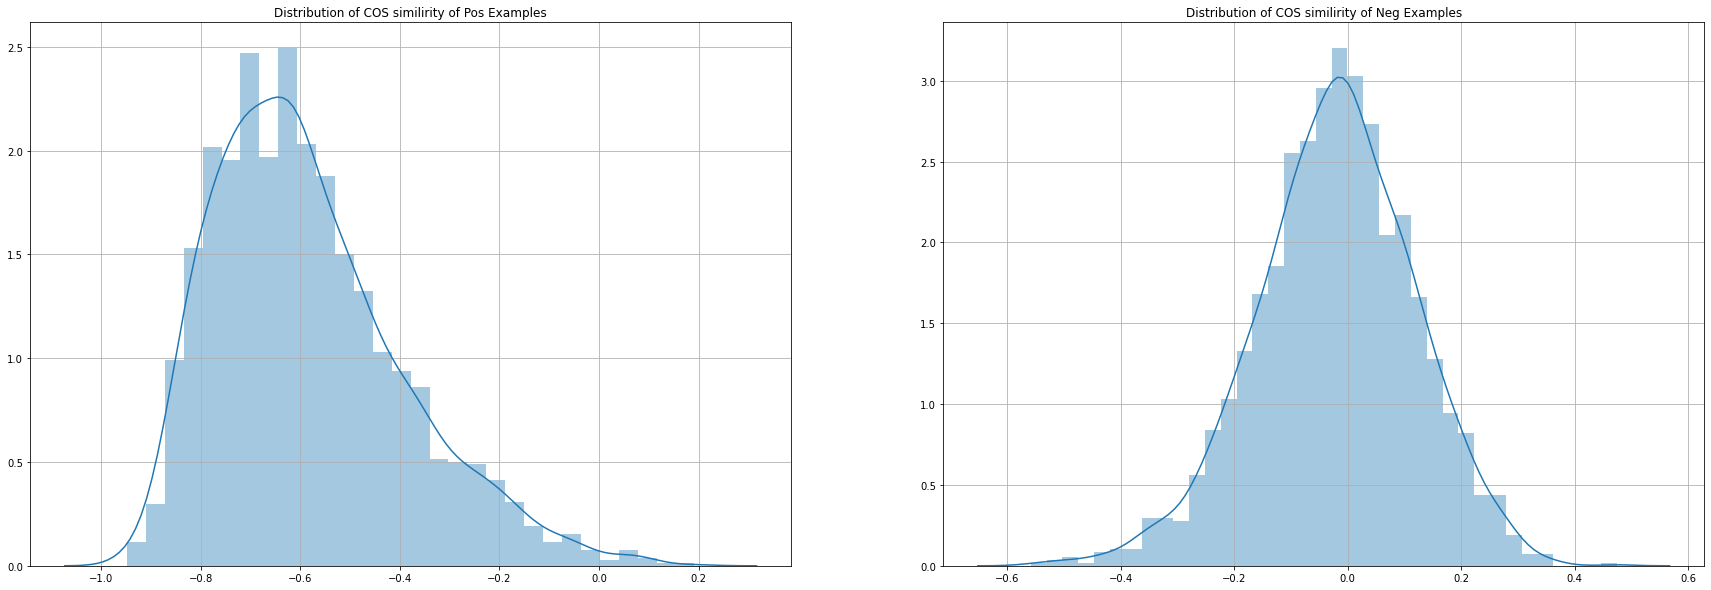

In [15]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
fig = sns.distplot(cosine_pos)
fig.grid(True)
fig.set_title("Distribution of COS similirity of Pos Examples")
plt.subplot(1,2,2)
fig = sns.distplot(cosine_neg)
fig.grid(True)
fig.set_title("Distribution of COS similirity of Neg Examples")
plt.show()

In [16]:
print("positive mean:", np.mean(cosine_pos))
print("positive std:", np.std(cosine_pos))
print("negative mean:", np.mean(cosine_neg))
print("negative std:", np.std(cosine_neg))

positive mean: -0.58535063
positive std: 0.1896022
negative mean: -0.02163216
negative std: 0.13909708


In [17]:
X1_embed = facenet.predict(X1)
X2_embed = facenet.predict(X2)
loss = cosine_loss(X1_embed, X2_embed)

In [18]:
def compute_metrics(threshold, loss,y):
    y_ = []
    for logit in np.array(loss):
        if logit<=threshold:
            y_.append(1)
        else:
            y_.append(0)
    y_ = np.array(y_)
    return accuracy_score(y, y_), precision_score(y, y_), recall_score(y, y_)

In [19]:
thresholds = np.linspace(-0.10, -0.35, 1000)
accuracies = []
precisions = []
recalls = []
for threshold in thresholds:
    accuracy, precision, recall = compute_metrics(threshold, loss,y)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

In [20]:
results = pd.DataFrame({"threshold": thresholds,
                        "accuracy":accuracies,
                        "precision": precisions,
                        "recall": recalls})

In [21]:
results.head(50)

,threshold,accuracy,precision,recall
0,-0.100000,0.856201,0.784850,0.981445
1,-0.100250,0.856934,0.785770,0.981445
2,-0.100501,0.857422,0.786385,0.981445
3,-0.100751,0.857422,0.786385,0.981445
4,-0.101001,0.857666,0.786693,0.981445
5,-0.101251,0.858154,0.787309,0.981445
6,-0.101502,0.858154,0.787309,0.981445
7,-0.101752,0.858398,0.787618,0.981445
8,-0.102002,0.858887,0.788235,0.981445
9,-0.102252,0.859375,0.788854,0.981445


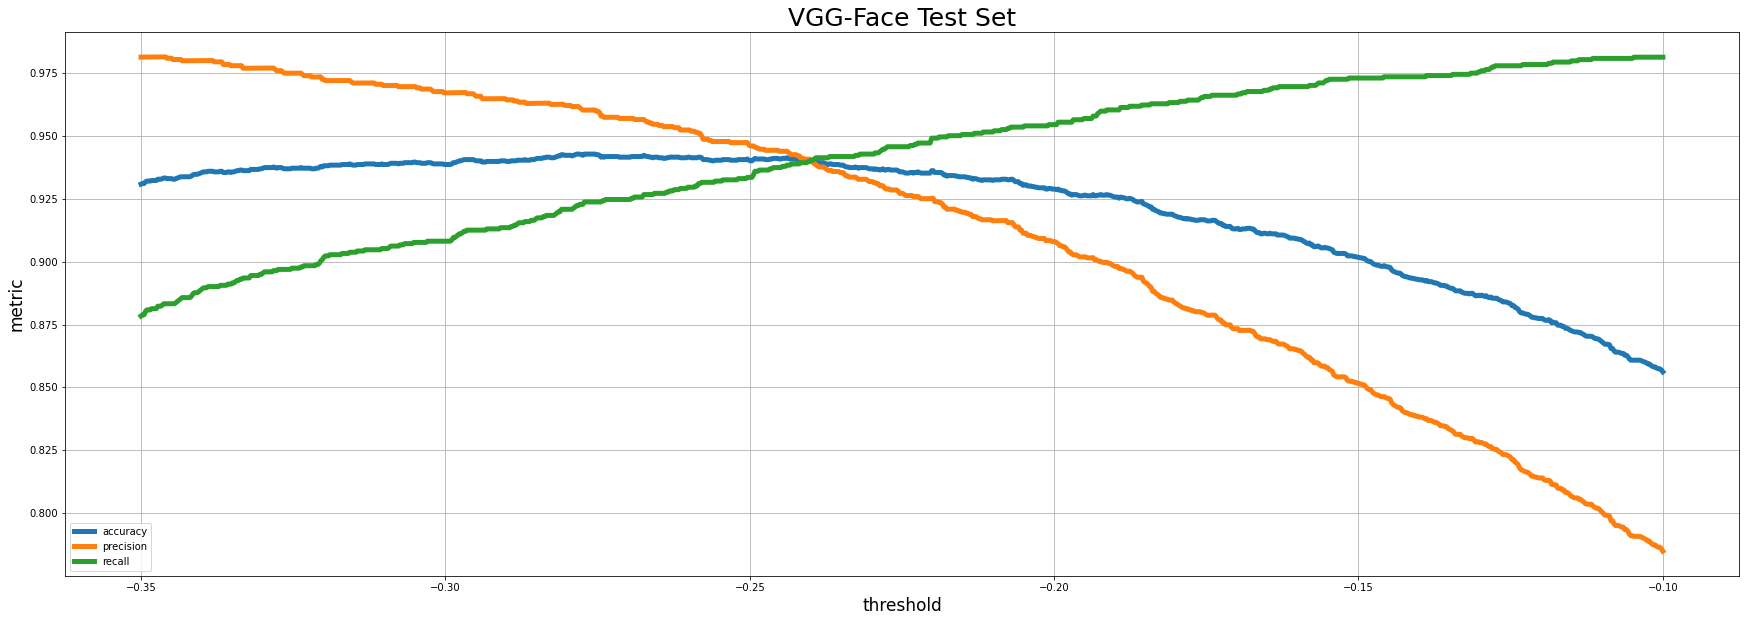

In [22]:
plt.figure(figsize=(30,10))
plt.plot(thresholds, accuracies, label = "accuracy", linewidth = 5)
plt.plot(thresholds, precisions, label = "precision", linewidth = 5)
plt.plot(thresholds, recalls, label = "recall", linewidth = 5)
plt.grid(True)
plt.xlabel("threshold", fontsize = 17)
plt.ylabel("metric", fontsize = 17)
plt.title("VGG-Face Test Set", fontsize =25)
plt.legend()
plt.show()